In [2]:
import pandas as pd
import numpy as np
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [3]:
series = pd.read_csv('trips_train_3.csv', header=None )

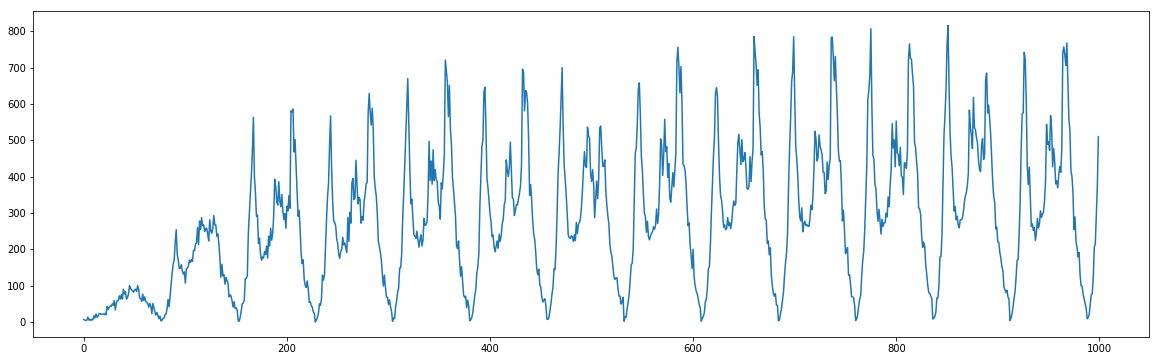

In [4]:
pyplot.figure(figsize=(20,6))
pyplot.plot(series.values[:1000])
pyplot.show()

In [5]:
# normalize features - 

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(series.values)
series = pd.DataFrame(scaled)

c:\users\kuno\miniconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [6]:
window_size = 78  # 78 steps in one day 

series_s = series.copy()
for i in range(window_size):
    series = pd.concat([series, series_s.shift(-(i+1))], axis = 1)
    
series.dropna(axis=0, inplace=True)

In [7]:
# Hacer lo mismo para los datos de prueba
test_series = pd.read_csv('trips_test_2.csv', header=None )
test_series = test_series.iloc[:24624, :]  # The rest are all 0s
test_scaled = scaler.fit_transform(test_series.values)
test_series = pd.DataFrame(test_scaled)

series_s = test_series.copy()
for i in range(window_size):
    test_series = pd.concat([test_series, series_s.shift(-(i+1))], axis = 1)
    
test_series.dropna(axis=0, inplace=True)

c:\users\kuno\miniconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [8]:
train = series
test = test_series

In [9]:
from sklearn.utils import shuffle
train = shuffle(train)

In [10]:
train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

In [11]:
train_X = train_X.values
train_y = train_y.values
test_X = test_X.values
test_y = test_y.values

In [12]:
train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)

In [13]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(input_shape = (window_size,1), output_dim= window_size, return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")
model.summary()

c:\users\kuno\miniconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=78, return_sequences=True, input_shape=(78, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 78, 78)            24960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 78, 78)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               343040    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 368,257
Trainable params: 368,257
Non-trainable params: 0
_________________________________________________________________


In [14]:
start = time.time()
model.fit(train_X,train_y,batch_size=window_size,epochs=30,validation_split=0.1)
print("> Compilation Time : ", time.time() - start)

Train on 35634 samples, validate on 3960 samples
Epoch 1/30
35634/35634 [==============================] - 416s 12ms/step - loss: 0.0288 - val_loss: 0.0156
Epoch 2/30
35634/35634 [==============================] - 410s 12ms/step - loss: 0.0172 - val_loss: 0.0122
Epoch 3/30
35634/35634 [==============================] - 403s 11ms/step - loss: 0.0153 - val_loss: 0.0114
Epoch 4/30
35634/35634 [==============================] - 413s 12ms/step - loss: 0.0143 - val_loss: 0.0113
Epoch 5/30
35634/35634 [==============================] - 390s 11ms/step - loss: 0.0134 - val_loss: 0.0099
Epoch 6/30
35634/35634 [==============================] - 396s 11ms/step - loss: 0.0124 - val_loss: 0.0096
Epoch 7/30
35634/35634 [==============================] - 424s 12ms/step - loss: 0.0118 - val_loss: 0.0090
Epoch 8/30
35634/35634 [==============================] - 399s 11ms/step - loss: 0.0109 - val_loss: 0.0073
Epoch 9/30
35634/35634 [==============================] - 384s 11ms/step - loss: 0.0097 - val_l

In [24]:
# Doing a prediction on all the test data at once
preds = model.predict(test_X)

In [51]:
preds = scaler.inverse_transform(preds)

In [18]:
actuals = scaler.inverse_transform(test_y)
#actuals = test_y

# from matplotlib import pyplot
# pyplot.figure(figsize=(20,6))
# pyplot.plot(actuals[:900])
# pyplot.plot(preds[:800])
# pyplot.show()

c:\users\kuno\miniconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [15]:
def moving_test_window_preds(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                    # Use this to store the prediction made on each test window
    moving_test_window = [test_X[0,:].tolist()]          # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    
    for i in range(n_future_preds):
        preds_one_step = model.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
        
    preds_moving = scaler.inverse_transform(np.array(preds_moving).reshape(-1, 1))
    
    return preds_moving

In [16]:
preds_moving = moving_test_window_preds(500)

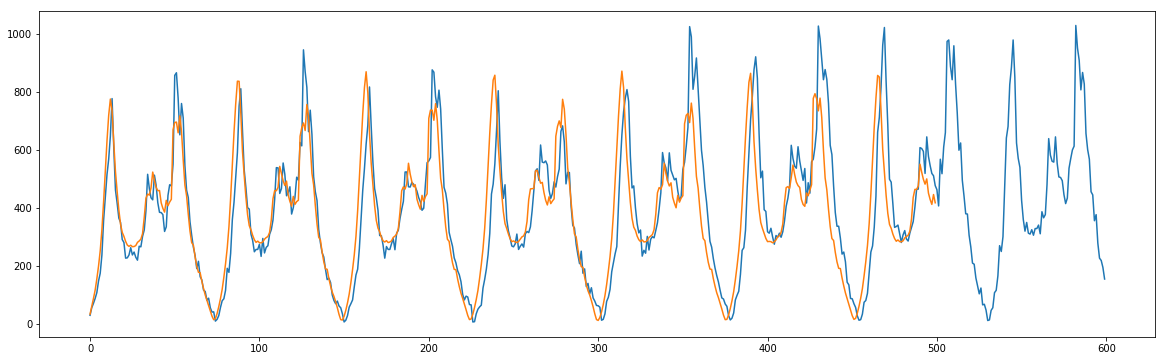

In [19]:
pyplot.figure(figsize=(20,6))
pyplot.plot(actuals[:600])
pyplot.plot(preds_moving[:600])
pyplot.show()

In [55]:
def moving_test_window_preds_mod(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = actuals[:500].tolist()                 # Use this to store the prediction made on each test window
    moving_test_window = test_X[:500, :]         # Creating the first test window

    for i in range(n_future_preds):
        preds_one_step = model.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(scaler.inverse_transform(preds_one_step[-1])[0]) # get the last value from the numpy 2D array and append to predictions
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step.reshape(500, 1, 1)), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
    
    return preds_moving

# Doing a prediction on all the test data at once
preds_moving = moving_test_window_preds_mod(50)

c:\users\kuno\miniconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\users\kuno\miniconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\users\kuno\miniconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single fea

c:\users\kuno\miniconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\users\kuno\miniconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\users\kuno\miniconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single fea

c:\users\kuno\miniconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\users\kuno\miniconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\users\kuno\miniconda3\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single fea

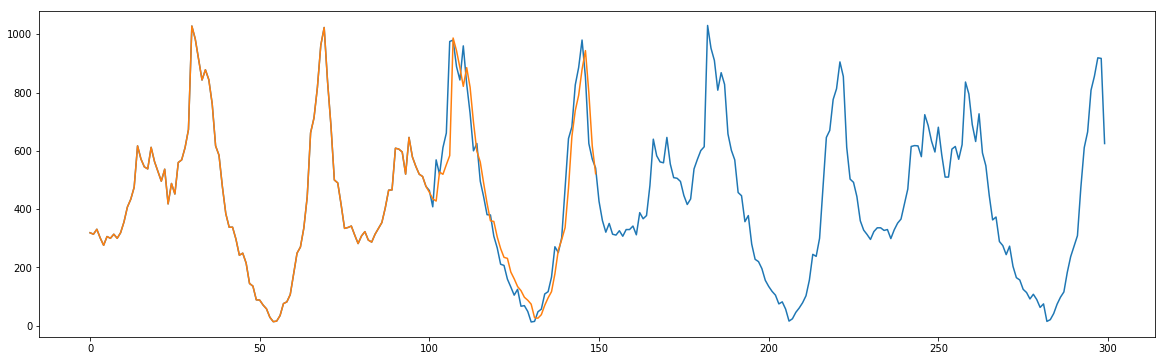

In [56]:
pyplot.figure(figsize=(20,6))
pyplot.plot(actuals[400:700])
pyplot.plot(preds_moving[400:])
pyplot.show()

In [67]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mean_squared_error(actuals[74:150], preds_moving[74:150])

2278.851703385667

In [66]:
mean_absolute_error(actuals[74:150], preds_moving[74:150])

36.71723704255725

In [28]:
np.array(test_X[0,:].tolist()).shape

(78, 1)

In [21]:
test_X.shape

(19682, 78, 1)

In [25]:
preds.shape

(19682, 1)